In [1]:
try:
    from rich import load_ipython_extension
    %load_ext rich
except ImportError:
    try:
        from rich import pretty
        pretty.install()
    except ImportError:
        pass

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Using the cleaned dataset created in assignment 1

In [3]:
data = pd.read_csv("../data/manipulated_data.csv")
data

,sex,age,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
0,Man,16-19,TOT,2018,547.9,38091,Stockholm,primary/lower secondary
1,Man,16-19,0,2018,0.0,13357,Stockholm,primary/lower secondary
2,Man,16-19,1-19,2018,137.9,17417,Stockholm,primary/lower secondary
3,Man,16-19,20-39,2018,106.1,3763,Stockholm,primary/lower secondary
4,Man,16-19,40-59,2018,77.2,1574,Stockholm,primary/lower secondary
...,...,...,...,...,...,...,...,...
409255,Woman,65-69,80-99,2012,0.9,10,Norrbotten,unknown
409256,Woman,70-75,TOT,2012,2.4,36,Norrbotten,unknown
409257,Woman,70-75,0,2012,0.0,11,Norrbotten,unknown
409258,Woman,70-75,1-19,2012,0.1,6,Norrbotten,unknown


Checking data types

In [4]:
data.dtypes


sex                        object
age                        object
income_bracket             object
year                        int64
total_sum_sek_millions    float64
number_of_persons           int64
region_name                object
level_of_education         object
dtype: object

To set data types correctly for each column the function and type map from assignment 1 is used.

In [5]:
def convert_types(type_map, df):
    for item in type_map.items():
        if item[1] == "int64":
            df[item[0]] = pd.to_numeric(df[item[0]], errors="coerce").astype("Int64")
        elif item[1] == "float64":
            df[item[0]] = pd.to_numeric(df[item[0]], errors="coerce").astype("float64")
        elif item[1] == "string":
            df[item[0]] = df[item[0]].astype("string")

In [6]:
type_map_data = {
    "region_name": "string",
    "level_of_education": "string",
    "sex": "string",
    "age": "string",
    "income_bracket": "string",
    "year": "int64",
    "total_sum_sek_millions": "float64",
    "number_of_persons": "int64",
}

convert_types(type_map_data, data)
data.dtypes


sex                       string[python]
age                       string[python]
income_bracket            string[python]
year                               Int64
total_sum_sek_millions           float64
number_of_persons                  Int64
region_name               string[python]
level_of_education        string[python]
dtype: object

I will try to classify which age the test instances has based on their features.

In [7]:
data["age"].unique().tolist()

['16-19', '20-29', '30-39', '40-49', '50-59', '60-64', '65-69', '70-75']

Number of instances for each age bin

In [8]:
data["age"].value_counts()


age
30-39    58938
40-49    57395
20-29    57333
50-59    55641
60-64    53044
65-69    52566
70-75    50595
16-19    23748
Name: count, dtype: Int64

Removing the TOT rows from income bracket beacause I believe it will not help the model and it doesn't make sense to keep it for this task.

In [9]:
data = data[data["income_bracket"] != "TOT"]

data

,sex,age,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
1,Man,16-19,0,2018,0.0,13357,Stockholm,primary/lower secondary
2,Man,16-19,1-19,2018,137.9,17417,Stockholm,primary/lower secondary
3,Man,16-19,20-39,2018,106.1,3763,Stockholm,primary/lower secondary
4,Man,16-19,40-59,2018,77.2,1574,Stockholm,primary/lower secondary
5,Man,16-19,60-79,2018,50.9,745,Stockholm,primary/lower secondary
...,...,...,...,...,...,...,...,...
409254,Woman,65-69,1-19,2012,0.0,4,Norrbotten,unknown
409255,Woman,65-69,80-99,2012,0.9,10,Norrbotten,unknown
409257,Woman,70-75,0,2012,0.0,11,Norrbotten,unknown
409258,Woman,70-75,1-19,2012,0.1,6,Norrbotten,unknown


Age map for hopefully boosting performance a bit.

In [10]:
age_map = {"16-19": 0, "20-29": 1, "30-39": 2, "40-49": 3, "50-59": 4, "60-64": 5, "65-69": 6, "70-75": 7}

In [11]:
data = data.copy()
data["age"] = data["age"].map(age_map).astype("int64")

data["age"].unique().tolist()

[0, 1, 2, 3, 4, 5, 6, 7]

In [12]:
labels = data[["age"]]
labels

,age
1,0
2,0
3,0
4,0
5,0
...,...
409254,6
409255,6
409257,7
409258,7


I will use all features in the first experiment.

In [13]:
features = data.drop(columns="age")
features

,sex,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
1,Man,0,2018,0.0,13357,Stockholm,primary/lower secondary
2,Man,1-19,2018,137.9,17417,Stockholm,primary/lower secondary
3,Man,20-39,2018,106.1,3763,Stockholm,primary/lower secondary
4,Man,40-59,2018,77.2,1574,Stockholm,primary/lower secondary
5,Man,60-79,2018,50.9,745,Stockholm,primary/lower secondary
...,...,...,...,...,...,...,...
409254,Woman,1-19,2012,0.0,4,Norrbotten,unknown
409255,Woman,80-99,2012,0.9,10,Norrbotten,unknown
409257,Woman,0,2012,0.0,11,Norrbotten,unknown
409258,Woman,1-19,2012,0.1,6,Norrbotten,unknown


Below I group the dataset by `level_of_education`, summing `total_sum_sek_millions` and `number_of_persons` for each education level.
Then plots each education level as a point, with `number_of_persons` on the x-axis and `total_sum_sek_millions` on the y-axis. Each point is colored by education level.
And fits a linear regression model to predict total income (`total_sum_sek_millions`) from population size (`number_of_persons`), using the aggregated data.
I include the regression line in the scatterplot.

This is done to visualize and model the relationship between population size and total income for each education level, showing both the data points and the overall trend.

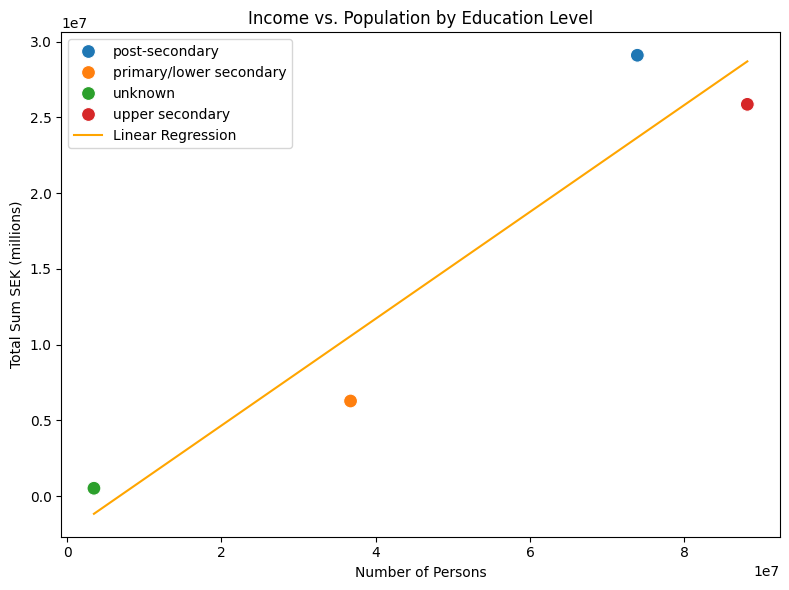

In [14]:
edu_group = (
    data.groupby("level_of_education").agg({"total_sum_sek_millions": "sum", "number_of_persons": "sum"}).reset_index()
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="number_of_persons",
    y="total_sum_sek_millions",
    data=edu_group,
    hue="level_of_education",
    palette="tab10",
    s=100,
)

X = edu_group[["number_of_persons"]]
y = edu_group["total_sum_sek_millions"]
model = LinearRegression()
model.fit(X, y)
xfit = np.linspace(X.min(), X.max(), 100)
xfit_df = pd.DataFrame(xfit, columns=["number_of_persons"])
yfit = model.predict(xfit_df)
plt.plot(xfit, yfit, color="orange", label="Linear Regression")

plt.xlabel("Number of Persons")
plt.ylabel("Total Sum SEK (millions)")
plt.title("Income vs. Population by Education Level")
plt.legend()
plt.tight_layout()
plt.show()

This code groups the data by region and education, calculates average income per person, clusters the groups into 4 clusters using k-means, and visualizes the clusters on a log-log scatterplot. This helps to identify patterns or groupings among regions based on income and population, with additional context from education levels.

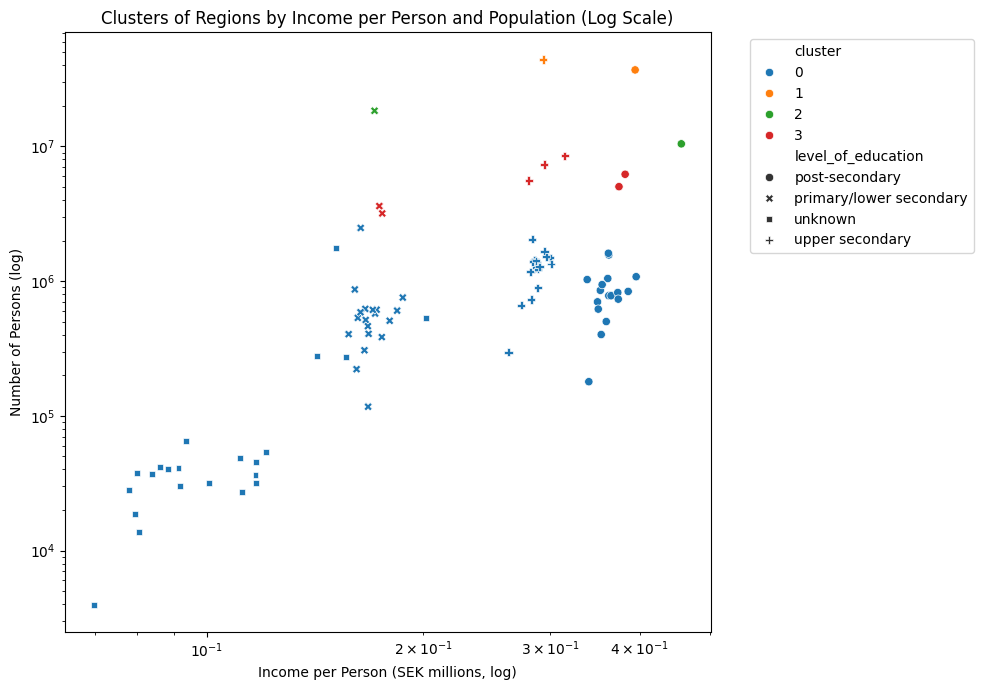

In [15]:
agg = (
    data.groupby(["region_name", "level_of_education"])
    .agg({"total_sum_sek_millions": "sum", "number_of_persons": "sum"})
    .reset_index()
)

agg["income_per_person"] = agg["total_sum_sek_millions"] / agg["number_of_persons"]

X_agg = agg[["income_per_person", "number_of_persons"]].fillna(0)

kmeans = KMeans(n_clusters=4, random_state=42)
agg["cluster"] = kmeans.fit_predict(X_agg)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="income_per_person", y="number_of_persons", hue="cluster", style="level_of_education", data=agg, palette="tab10"
)
plt.xscale("log")
plt.yscale("log")
plt.title("Clusters of Regions by Income per Person and Population (Log Scale)")
plt.xlabel("Income per Person (SEK millions, log)")
plt.ylabel("Number of Persons (log)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Using GMM instead the clusters are similar but not exactly the same.

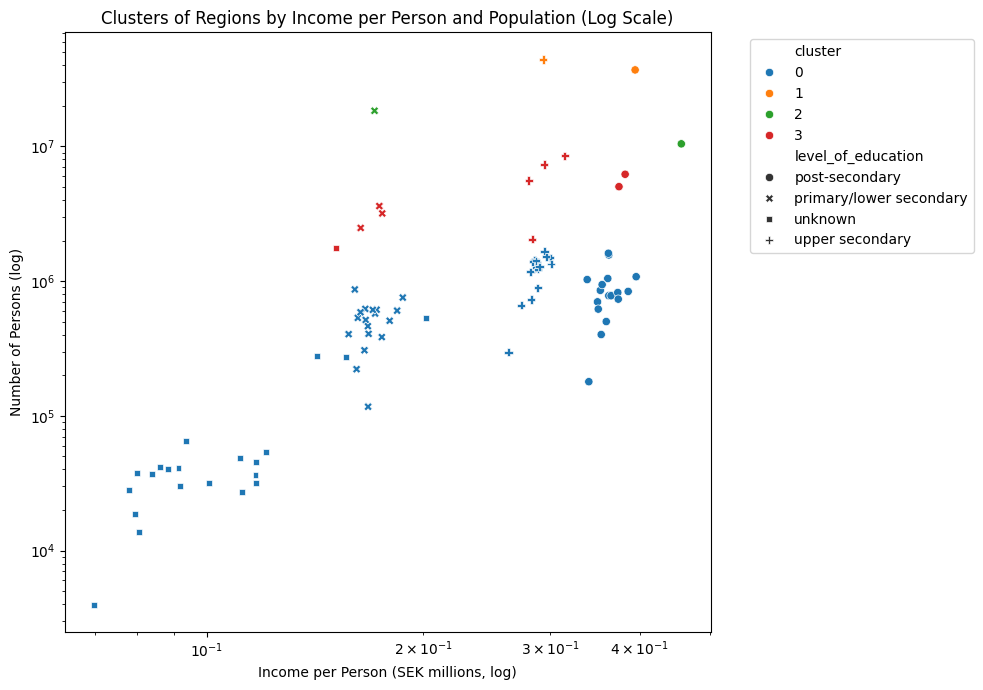

In [ ]:
gmm = GMM(n_components=4, random_state=42)
agg["cluster"] = gmm.fit_predict(X_agg)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="income_per_person", y="number_of_persons", hue="cluster", style="level_of_education", data=agg, palette="tab10"
)
plt.xscale("log")
plt.yscale("log")
plt.title("Clusters of Regions by Income per Person and Population (Log Scale)")
plt.xlabel("Income per Person (SEK millions, log)")
plt.ylabel("Number of Persons (log)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Here I create my test and train splits and show how they look. Using stratify to preserve balanced buckets.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, random_state=42, stratify=labels, shuffle=True)

X_train

,sex,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
113665,Man,220-239,2020,17.3,75,Uppsala,post-secondary
346363,Man,400-499,2013,124.8,285,Dalarna,primary/lower secondary
261373,Man,1000+,2015,9.1,7,Värmland,primary/lower secondary
38648,Woman,140-159,2011,60.9,407,Blekinge,upper secondary
262689,Man,120-139,2015,13.5,103,Örebro,primary/lower secondary
...,...,...,...,...,...,...,...
114658,Man,320-339,2020,56.1,170,Södermanland,upper secondary
65106,Man,180-199,2023,2.9,15,Gotland,post-secondary
355475,Man,120-139,2022,19.6,149,Uppsala,upper secondary
348529,Woman,500-599,2013,33.0,61,Gävleborg,post-secondary


In [19]:
y_train

,age
113665,6
346363,5
261373,6
38648,6
262689,6
...,...
114658,6
65106,6
355475,2
348529,6


HistGradientBoostingClassifier can handle catagorical features if added as seperate list of columns name so thats what is done here.

In [20]:
cat_features = features.drop(columns=["year", "total_sum_sek_millions", "number_of_persons"]).columns.to_list()

cat_features

['sex', 'income_bracket', 'region_name', 'level_of_education']

Fit HistGradientBoostingClassifier with the standard settings for hyperparameters with the only addition of using class_weight="balanced" to balance out that number of instances in classes differ.

In [ ]:
hgb_clf = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.1,
    max_iter=100,
    categorical_features=cat_features,
    l2_regularization=0,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=1,
    random_state=42,
    class_weight="balanced",
).fit(X=X_train, y=y_train.squeeze())

Binning 0.014 GB of training data: 0.050 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.002 s
Fitting gradient boosted rounds:
Fit 800 trees in 6.999 s, (24800 total leaves)
Time spent computing histograms: 1.967s
Time spent finding best splits:  0.328s
Time spent applying splits:      1.330s
Time spent predicting:           0.308s


Make predictions on the test set with the classifier.

In [22]:
y_pred_bad = hgb_clf.predict(X=X_test)

Print the classification report for the comparison of true labels and predicted labels.

As seen below this seems to be a though task for the classifier. Only the age of 16-19 was predicted fairly accurate. This is probably because most of the other age buckets doesn't tend to be that different from each other.

In [23]:
print(classification_report(y_test, y_pred_bad))

              precision    recall  f1-score   support

           0       0.48      0.95      0.64      6468
           1       0.52      0.50      0.51     16461
           2       0.46      0.29      0.36     16942
           3       0.36      0.24      0.29     16479
           4       0.43      0.32      0.37     15953
           5       0.42      0.52      0.47     15176
           6       0.36      0.47      0.41     15033
           7       0.47      0.53      0.50     14442

    accuracy                           0.44    116954
   macro avg       0.44      0.48      0.44    116954
weighted avg       0.43      0.44      0.42    116954



Print overall accuracy to highlight it.

In [24]:
hgb_clf.score(X=X_test, y=y_test)

0.43583802178634334

Create a confusion matrix that show True/False positives and negatives.

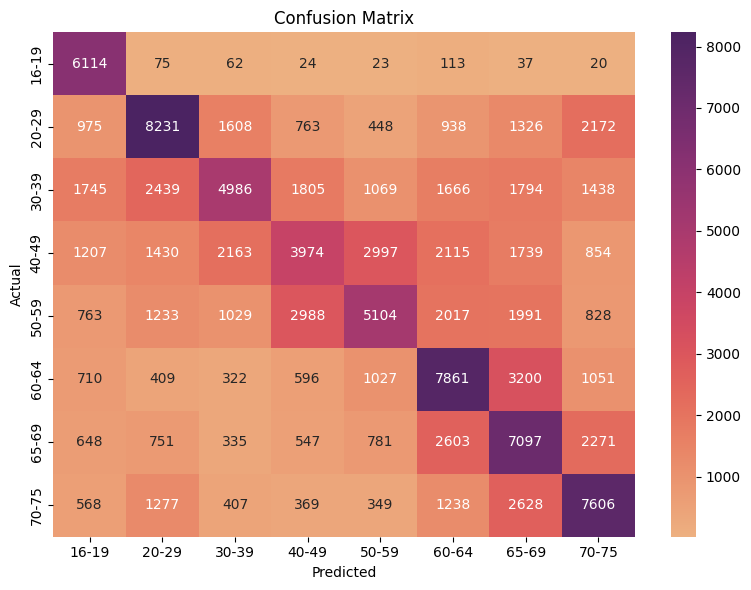

In [25]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_bad)

labels_names = ["16-19", "20-29", "30-39", "40-49", "50-59", "60-64", "65-69", "70-75"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare", xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Do a ten-fold cross validation to see if the accuracy is about the same.

StratifiedKFold is used to preserve the balance of age buckets. 

In [26]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(hgb_clf, features, labels.squeeze(), cv=cv, verbose=1)
scores.mean()

Binning 0.018 GB of training data: 0.052 s
Binning 0.002 GB of validation data: 0.005 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.936 s, (24800 total leaves)
Time spent computing histograms: 3.192s
Time spent finding best splits:  0.449s
Time spent applying splits:      2.226s
Time spent predicting:           0.520s
Binning 0.018 GB of training data: 0.049 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 12.300 s, (24800 total leaves)
Time spent computing histograms: 3.585s
Time spent finding best splits:  0.488s
Time spent applying splits:      2.445s
Time spent predicting:           0.576s
Binning 0.018 GB of training data: 0.045 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 12.897 s, (24800 total leaves)
Time spent computing histograms: 3.942s
Time spent finding best splits:  0.559s
Time spent applying splits:      2.550s
Time spent predicting:           0.572s
Binning 0.018

0.438134243095124

Hyperparameter Tuning to hopefully boost performance.

In [27]:
learning_rate = [0.01, 0.05, 0.1, 0.2]
max_iter = [100, 300, 500, 1000]
max_leaf_nodes = [10, 20, 31, 50, 100] # default = 31
max_depth = [3, 5, 8, None]
min_samples_leaf = [1, 5, 10, 20, 50]
l2_regularization = [0, 1e-3, 1e-2, 1e-1, 1]
max_features = [0.3, 0.5, 0.7, 1.0]

In [28]:
param_grid = [
    {
        "learning_rate": learning_rate,
        "max_iter": max_iter,
        "max_leaf_nodes": max_leaf_nodes,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "l2_regularization": l2_regularization,
        "max_features": max_features,
    }
]

StratifiedKFold is used to preserve the balance of age buckets and RadomizedSearch was used instead of gridsearch to speed up the process. Scoring is f1_macro to try to get as good accuracy on each class as possible. 

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
hgb_clf = RandomizedSearchCV(
    HistGradientBoostingClassifier(verbose=1, categorical_features=cat_features, class_weight="balanced"),
    param_grid,
    random_state=42,
    verbose=1,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1,
)
search = hgb_clf.fit(features, labels.squeeze())
search.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Binning 0.018 GB of training data: Binning 0.018 GB of training data: Binning 0.018 GB of training data: Binning 0.018 GB of training data: Binning 0.018 GB of training data: 0.466 s
Binning 0.002 GB of validation data: Binning 0.018 GB of training data: 0.224 s
Binning 0.002 GB of validation data: 0.044 s
Fitting gradient boosted rounds:
0.019 s
Fitting gradient boosted rounds:
0.242 s
Binning 0.002 GB of validation data: 0.021 s
Fitting gradient boosted rounds:
0.295 s
Binning 0.002 GB of validation data: 0.057 s
0.254 s
Fitting gradient boosted rounds:
Binning 0.002 GB of validation data: 0.021 sBinning 0.018 GB of training data: 
Fitting gradient boosted rounds:
0.417 s
Binning 0.002 GB of validation data: 0.025 s
Fitting gradient boosted rounds:
Binning 0.018 GB of training data: 0.245 s
Binning 0.002 GB of validation data: 0.022 s
Fitting gradient boosted rounds:
0.227 s
Binning 0.002 GB of validation data: 0.020 s
Fi


{
    'min_samples_leaf': 1,
    'max_leaf_nodes': 100,
    'max_iter': 1000,
    'max_features': 0.5,
    'max_depth': None,
    'learning_rate': 0.05,
    'l2_regularization': 0.01
}

Shows the best model configurations found.

In [30]:
search.best_estimator_

HistGradientBoostingClassifier(categorical_features=['sex', 'income_bracket',
                                                     'region_name',
                                                     'level_of_education'],
                               class_weight='balanced', l2_regularization=0.01,
                               learning_rate=0.05, max_features=0.5,
                               max_iter=1000, max_leaf_nodes=100,
                               min_samples_leaf=1, verbose=1)

Fit a new model with the best configurations.

In [57]:
hgb_clf = search.best_estimator_
hgb_clf.fit(X_train, y_train.squeeze())
y_pred_better = hgb_clf.predict(X_test)

Binning 0.014 GB of training data: 0.032 s
Binning 0.002 GB of validation data: 0.002 s
Fitting gradient boosted rounds:
Fit 8000 trees in 134.700 s, (800000 total leaves)
Time spent computing histograms: 32.155s
Time spent finding best splits:  25.310s
Time spent applying splits:      25.670s
Time spent predicting:           3.959s


New report with slightly better results but nothing to significant.

In [58]:
print(classification_report(y_pred_better, y_test))

              precision    recall  f1-score   support

           0       0.86      0.72      0.79      7749
           1       0.60      0.58      0.59     17043
           2       0.43      0.50      0.46     14635
           3       0.33      0.40      0.36     13465
           4       0.41      0.47      0.44     14165
           5       0.59      0.51      0.55     17482
           6       0.49      0.44      0.46     16974
           7       0.60      0.56      0.58     15441

    accuracy                           0.51    116954
   macro avg       0.54      0.52      0.53    116954
weighted avg       0.53      0.51      0.52    116954



In [59]:
hgb_clf.score(X=X_test, y=y_test)

0.5117653094378987

In [60]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(hgb_clf, features, labels.squeeze(), cv=cv, verbose=1)
scores.mean()

Binning 0.018 GB of training data: 0.053 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 8000 trees in 152.444 s, (800000 total leaves)
Time spent computing histograms: 38.206s
Time spent finding best splits:  25.691s
Time spent applying splits:      28.743s
Time spent predicting:           4.971s
Binning 0.018 GB of training data: 0.044 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 8000 trees in 161.565 s, (800000 total leaves)
Time spent computing histograms: 40.552s
Time spent finding best splits:  27.620s
Time spent applying splits:      30.417s
Time spent predicting:           5.139s
Binning 0.018 GB of training data: 0.044 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 8000 trees in 135.446 s, (800000 total leaves)
Time spent computing histograms: 33.859s
Time spent finding best splits:  22.614s
Time spent applying splits:      25.627s
Time spent predicting:           4.

0.520816036549862

A new confusion matrix to show the results from the best estimator.

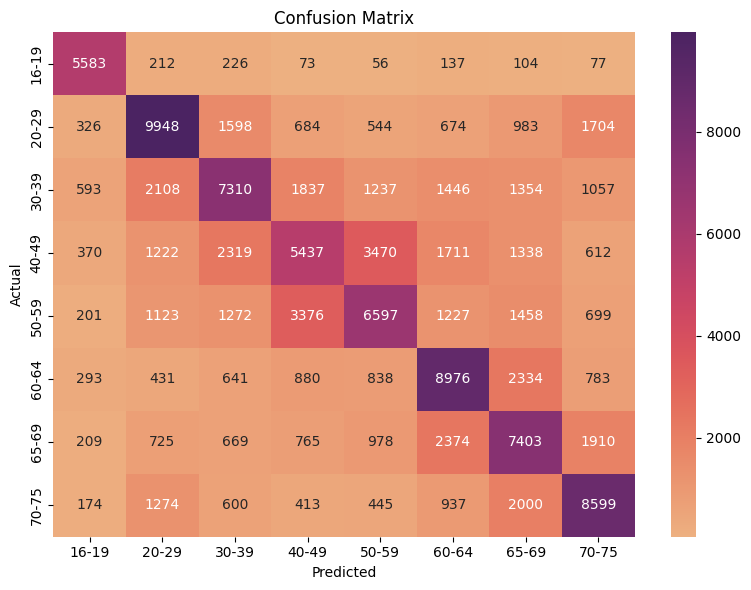

In [61]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_better)

labels_names = ["16-19", "20-29", "30-39", "40-49", "50-59", "60-64", "65-69", "70-75"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare", xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Made some feature importance searching, all features seem to be useful for the model.

In [ ]:
pi = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)
pi["importances_mean"]


array([0.097098  , 0.25144644, 0.08515741, 0.21500647, 0.29579293,
       0.23299673, 0.2350873 ])

This is just for a cleaner visualization.

In [ ]:
pd.DataFrame([features.columns, pi["importances_mean"]]).T.set_index(0)

,1
0,
sex,0.097098
income_bracket,0.251446
year,0.085157
total_sum_sek_millions,0.215006
number_of_persons,0.295793
region_name,0.232997
level_of_education,0.235087


A test was performed on the five most important features using the parameters from the tuning.

In [68]:
X_train_most = X_train.drop(columns=["sex", "year"])
X_test_most = X_test.drop(columns=["sex", "year"])

I slice the cat features array to use it in the model without the sex column

In [81]:
cat_features[1:]

['income_bracket', 'region_name', 'level_of_education']

In [82]:
hgb_clf = HistGradientBoostingClassifier(
    min_samples_leaf=1,
    max_leaf_nodes=100,
    max_iter=1000,
    max_features=0.5,
    max_depth=None,
    learning_rate=0.05,
    l2_regularization=0.01,
    verbose=1,
    class_weight="balanced",
    categorical_features=cat_features[1:],
)

Accuracy was decreased to even worse than the initial model.

In [83]:
hgb_clf.fit(X_train_most, y_train.squeeze())
hgb_clf.score(X=X_test_most, y=y_test)

Binning 0.010 GB of training data: 0.031 s
Binning 0.001 GB of validation data: 0.002 s
Fitting gradient boosted rounds:
Fit 3944 trees in 51.160 s, (394400 total leaves)
Time spent computing histograms: 11.185s
Time spent finding best splits:  9.350s
Time spent applying splits:      10.221s
Time spent predicting:           1.827s


0.3994818475639995

A test was performed on the two least important features using the parameters from the tuning.

In [87]:
X_train_least = X_train.drop(columns=["income_bracket", "total_sum_sek_millions", "number_of_persons", "region_name", "level_of_education"])
X_test_least = X_test.drop(
    columns=["income_bracket", "total_sum_sek_millions", "number_of_persons", "region_name", "level_of_education"]
)

Here sex is the only categorical feature I have in the data so I will give it as argument to the categorical_features parameter.

In [102]:
hgb_clf = HistGradientBoostingClassifier(
    min_samples_leaf=1,
    max_leaf_nodes=100,
    max_iter=1000,
    max_features=0.5,
    max_depth=None,
    learning_rate=0.05,
    l2_regularization=0.01,
    verbose=1,
    class_weight="balanced",
    categorical_features=["sex"]
)

As expected the model got even worse than just guessing on the same class all the time.

In [103]:
hgb_clf.fit(X_train_least, y_train.squeeze())
hgb_clf.score(X=X_test_least, y=y_test)

Binning 0.004 GB of training data: 0.019 s
Binning 0.000 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
Fit 160 trees in 0.994 s, (1363 total leaves)
Time spent computing histograms: 0.199s
Time spent finding best splits:  0.032s
Time spent applying splits:      0.175s
Time spent predicting:           0.047s


0.10889751526241086

Which class is of a majority? I will predict only the majority class and see which accuracy I can achieve. Probably to many classes for this to be useful but will do it anyway.

In [104]:
y_train.value_counts()


age
2      39532
3      38452
1      38408
4      37224
5      35410
6      35075
7      33698
0      15091
Name: count, dtype: int64

Class 2 is of majority but the classes are almost balanced and only class 0 is much smaller than the other ones. Therefore, only predicting class two will yield approximately 1/8 accuracy.

In [105]:
y_majority = [2] * len(y_test)
accuracy_score(y_true=y_test, y_pred=y_majority)

0.14486037245412725

Checking for a normal distribution is useful, because it is often a requirement for using other metrics that the data is normally distributed.

In [106]:
pg.normality(data)

/home/joel/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 389844.
  res = hypotest_fun_out(*samples, **kwds)
/home/joel/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 389844.
  res = hypotest_fun_out(*samples, **kwds)
/home/joel/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 389844.
  res = hypotest_fun_out(*samples, **kwds)


,W,pval,normal
age,0.935780,2.566071e-126,False
year,0.943760,1.941717e-122,False
total_sum_sek_millions,0.118112,1.793411e-215,False
number_of_persons,0.184068,1.753375e-212,False


A pairwise correlation analysis with all the columns of the dataframe is done here. Spearman correlation is used because the normality check indicated that the data wasn't normally distributed.

In [107]:
pg.pairwise_corr(data, method="spearman")

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,age,year,spearman,two-sided,389844,-0.015166,"[-0.02, -0.01]",2.801629e-21,1.0
1,age,total_sum_sek_millions,spearman,two-sided,389844,0.042637,"[0.04, 0.05]",2.793309e-156,1.0
2,age,number_of_persons,spearman,two-sided,389844,-0.079050,"[-0.08, -0.08]",0.000000e+00,1.0
3,year,total_sum_sek_millions,spearman,two-sided,389844,-0.026152,"[-0.03, -0.02]",5.922235e-60,1.0
4,year,number_of_persons,spearman,two-sided,389844,-0.044662,"[-0.05, -0.04]",2.712087e-171,1.0
5,total_sum_sek_millions,number_of_persons,spearman,two-sided,389844,0.793053,"[0.79, 0.79]",0.000000e+00,1.0


**Make a new Pandas DataFrame with "classifier correctness" labels.** This DataFrame should have:

- One **column per classifier**, e.g. the "bad" classifier before hyperparameter tuning, the "better" classifier from after tuning, and the "majority" classifier.
- One **row per instance in your test set**.
- A value of **`True` or `False` in each cell**, depending on whether the classifier _(column)_ correctly classified the instance _(row)_ or not.

Your resulting DataFrame could look something like this:

|       | **better** | **bad**  | **majority** |
|-------|----------|----------|--------------|
| **0** | True     | False    | False        |
| **1** | True     | False    | False        |
| **2** | True     | True     | True         |
| ...   | ...      | ...      | ...          |

In [ ]:
y_majority_df = pd.DataFrame(
    y_majority,
    index=X_test.index,
    columns=["age"],
)
y_majority_df

,age
180857,2
234529,2
16578,2
252931,2
293568,2
...,...
234736,2
3371,2
407777,2
78508,2


In [ ]:
y_pred_better_df = pd.DataFrame(
    y_pred_better,
    index=X_test.index,
    columns=["age"],
)
y_pred_better_df

,age
180857,7
234529,6
16578,1
252931,4
293568,7
...,...
234736,7
3371,0
407777,5
78508,3


In [ ]:
y_pred_bad_df = pd.DataFrame(
    y_pred_bad,
    index=X_test.index,
    columns=["age"],
)
y_pred_bad_df

,age
180857,7
234529,5
16578,1
252931,5
293568,7
...,...
234736,7
3371,0
407777,6
78508,3


In [ ]:
df_eval = pd.DataFrame(
    {
        "better": y_pred_better_df["age"] == y_test["age"],
        "bad": y_pred_bad_df["age"] == y_test["age"],
        "majority": y_majority_df["age"] == y_test["age"],
    }
)
df_eval

,better,bad,majority
180857,True,True,False
234529,True,False,False
16578,False,False,False
252931,True,False,False
293568,False,False,False
...,...,...,...
234736,True,True,False
3371,True,True,False
407777,False,True,False
78508,True,True,False


**Is the "bad" model (no hyperparameter tuning) still significantly better than the "majority" class model?**

We answer this question by using **McNemar's test,** using a significance level of $0.05$.  This means that if McNemar's test gives us a $p$-value $< 0.05$, we accept that there is a significant difference between our two classifiers.

In [ ]:
observed, stats = pg.chi2_mcnemar(df_eval, "bad", "majority")
stats

,chi2,dof,p-approx,p-exact
mcnemar,19985.863694,1,0.0,0.0


**Is the "better" model (from after tuning) significantly better than the "bad" model (from before tuning)?**  Same as above, just comparing different columns.

In [ ]:
observed, stats = pg.chi2_mcnemar(df_eval, "better", "bad")
stats

,chi2,dof,p-approx,p-exact
mcnemar,2772.168794,1,0.0,0.0


**Perform a principal component analysis (PCA).** Two dimensions are a common choice to make them suitable for visualization and then results is plotted.


### The code below is doing following:
- **Selects numeric columns**: `"year"`, `"total_sum_sek_millions"`, and `"number_of_persons"` from your dataset.
- **Standardizes** these features (mean=0, std=1) using `StandardScaler`.
- **Performs PCA** (Principal Component Analysis) to reduce these 3 features to 2 principal components (`PC1`, `PC2`).
- **Creates a DataFrame** with the two principal components and the corresponding `"age"` class.
- **Plots** a scatterplot of the data in the new 2D PCA space, coloring each point by its age group.

**Plot**
- The plot shows how the data is distributed in the space of the two most important linear combinations of the numeric features.
- Each point represents an instance, colored by its age group.
- In the plot, the age groups appear highly mixed, indicating that `"year"`, `"total_sum_sek_millions"`, and `"number_of_persons"` do **not** provide strong separation between age classes after PCA.

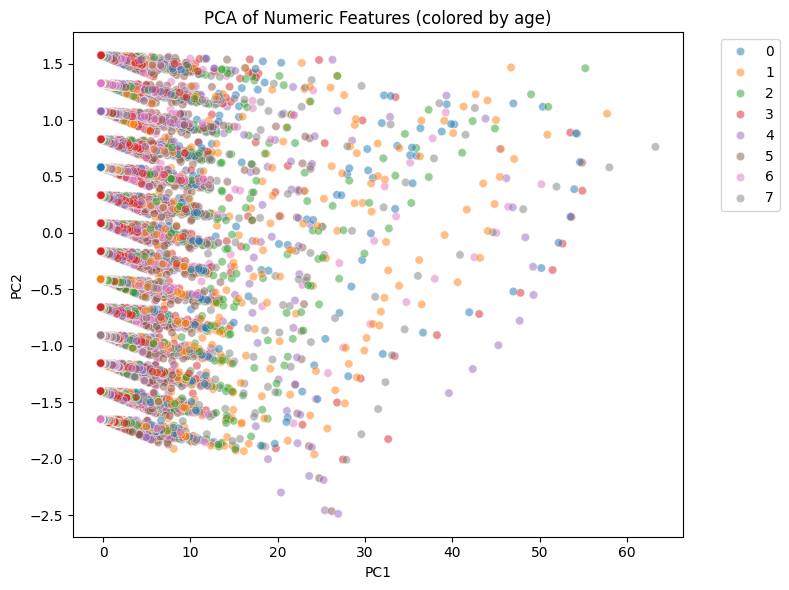

In [ ]:
numeric_cols = ["year", "total_sum_sek_millions", "number_of_persons"]
X_numeric = data[numeric_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["age"] = data.loc[X_numeric.index, "age"].astype(str)

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="age", data=pca_df, palette="tab10", alpha=0.5)
plt.title("PCA of Numeric Features (colored by age)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()